In [1]:
#-----------------------------------------------------------------------------------------------------------------#
# MIT License
#
# Copyright (c) 2022 José Luis Jiménez Arévalo, Eduardo García Olmos and Perla Vanessa Jaime Gaytan
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.
#-----------------------------------------------------------------------------------------------------------------#

#------------------------------------------------------------------------------------------------------------------
#   Installs
#------------------------------------------------------------------------------------------------------------------
#pip install richdem
#pip install pickle5
#pip install simpleai

#------------------------------------------------------------------------------------------------------------------
#   Imports
#------------------------------------------------------------------------------------------------------------------
from pathlib import Path
import copy
import math
import matplotlib
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import plotly.graph_objects as px
import random
import richdem as rd
from datetime import datetime
from matplotlib.colors import LightSource
from matplotlib.path import Path
from matplotlib.widgets import RadioButtons
from scipy.spatial.distance import pdist, squareform
from scipy.stats import kurtosis, skew
from skimage.feature import graycomatrix, graycoprops
from skimage.transform import downscale_local_mean
from sklearn import datasets 
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import svm
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeClassifier

# Classification


In [2]:
file_name = 'Data/navigability.obj'
inputFile = open(file_name, 'rb')
data = pickle.load(inputFile)
n_img = len(data)

#------------------------------------------------------------------------------------------------------------------
#   Process features of each image
#------------------------------------------------------------------------------------------------------------------

feature_names = ['Max slope','Mean slope','Slope variance','Slope skewness','Slope kurtosis',
                 'Max depression','Mean depression','Depression variance','Depression skewness',
                 'Depression kurtosis',
                 'Max rise','Mean rise','Rise variance','Rise skewness','Rise kurtosis',
                 'GLCM - Disimilaridad','GLCM - Correlación']
n_features = len(feature_names)

features = np.zeros([n_img, n_features])
original_labels = np.zeros([n_img])

for i in range(n_img):

    original_labels[i] = data[i][0]
    
    # Slope
    slope = data[i][3]
    features[i, 2] = slope.max()
    features[i, 3] = slope.mean()
    features[i, 4] = slope.var()
    features[i, 5] = skew(slope.flatten())
    features[i, 6] = kurtosis(slope.flatten()) 

    # Depression
    depression = data[i][4]
    features[i, 7] = depression.max()
    features[i, 8] = depression.mean()
    features[i, 9] = depression.var()
    features[i, 10] = skew(depression.flatten())
    features[i, 11] = kurtosis(depression.flatten())

    # Rise
    rise = data[i][5]    
    features[i, 12] = rise.max()
    features[i, 13] = rise.mean()
    features[i, 14] = rise.var()
    features[i, 15] = skew(rise.flatten())
    features[i, 16] = kurtosis(rise.flatten())

    # Data
    surface = (data[i][2]-data[i][2].min()).astype(int)
    glcm = graycomatrix(surface, distances=[5], angles=[0], levels=1024,
                        symmetric=True, normed=True)
    features[i, 0] = graycoprops(glcm, 'dissimilarity')[0,0]
    features[i, 1] = graycoprops(glcm, 'correlation')[0,0]

#------------------------------------------------------------------------------------------------------------------
#   Calculate feature averages per class
#------------------------------------------------------------------------------------------------------------------    

labels = original_labels.copy()
classes = np.unique(labels)
n_classes = len(classes)
class_names = [str(int(c)) for c in classes]

feature_means = np.zeros([n_classes, n_features])

for i in range(n_classes):
    for j in range(n_features):
        feature_means[i, j] = features[labels == classes[i], j].mean()
# Feature plots
cols = 5
rows = int(n_features/cols) + (n_features%cols>0)
#fig, axs = plt.subplots(rows,cols)

#for i in range(n_features):
#    r = int(i/cols)
#    c = i-r*cols
#    
#    values = [row[i] for row in feature_means]
#    axs[r][c].bar(class_names, values)
#    axs[r][c].set_title(feature_names[i])

#for i in range(n_features, rows*cols):
#    r = int(i/cols)
#    c = i - r*cols
#    axs[r, c].axis('off')

#fig.suptitle("Feature values")
#plt.show()

labels = original_labels.copy()
labels[labels==2] = 1
labels[labels==3] = 4
n_classes = len(np.unique(labels))

In [3]:
%%capture
#------------------------------------------------------------------------------------------------------------------
#   Classification model (SVM lineal)
#------------------------------------------------------------------------------------------------------------------
  
nfolds = 5
kf = StratifiedKFold(n_splits=nfolds, shuffle = True)
clf = svm.SVC(kernel = 'linear')

acc = 0
recall = [0]*n_classes
precision = [0]*n_classes

for train_index, test_index in kf.split(features, labels):
    
    # Training phase    
    x_train = features[train_index, :]    
    y_train = labels[train_index]    
    clf.fit(x_train, y_train)    

    # Test phase    
    x_test = features[test_index, :]    
    y_test = labels[test_index]        
    y_pred = clf.predict(x_test)
    print(y_pred)
    
    # Calculate confusion matrix and model performance    
    cm = confusion_matrix(y_test, y_pred)    
    #print('Confusion matrix\n', cm)
    
    #print(cm)
    
    acc_i = sum(cm[i][i] for i in range(n_classes))/len(y_test)
    acc += acc_i
    
    recall_i = [0]*n_classes
    precision_i = [0]*n_classes
    for m in range(n_classes):
        recall_i[m] = cm[m][m] / sum(cm[m][i] for i in range(n_classes))
        precision_i[m] = cm[m][m] / sum(cm[i][m] for i in range(n_classes))
        
        recall[m] += recall_i[m]
        precision[m] += precision_i[m]
        
    #print('Accuracy = ', acc_i)
    #print('Recall = ', recall_i)
    #print('Precision = ', precision_i)

cv_results = cross_validate(clf, features, labels, cv=nfolds, scoring = ('accuracy', 'recall_micro'))
accuracy = cv_results['test_accuracy'].sum()/nfolds 

print('Accuracy using cross-validation: ', accuracy)
acc = acc/nfolds
print('Accuracy = ', acc)

recall = [i/nfolds for i in recall]
print('Recall = ', recall)

precision = [i/nfolds for i in precision]
print('Precision = ', precision)

# 20x20

In [4]:
#------------------------------------------------------------------------------------------------------------------
#   Configuration
#------------------------------------------------------------------------------------------------------------------

file_name = 'Data/map.IMG'   # Data file
n_img = 5                           # Number of images
subimg_size = 20                    # Image size


#------------------------------------------------------------------------------------------------------------------
#   Surface map
#------------------------------------------------------------------------------------------------------------------

data_file = open(file_name, "rb")

endHeader = False;
while not endHeader:
    line = data_file.readline().rstrip().lower()

    sep_line = line.split(b'=')
       
    if len(sep_line) == 2:
        itemName = sep_line[0].rstrip().lstrip()
        itemValue = sep_line[1].rstrip().lstrip()

        if itemName == b'valid_maximum':
            maxV = float(itemValue)
        elif itemName == b'valid_minimum':
            minV = float(itemValue)
        elif itemName == b'lines':
            n_rows = int(itemValue)
        elif itemName == b'line_samples':
            n_columns = int(itemValue)
        elif itemName == b'map_scale':
            scale_str = itemValue.split()
            if len(scale_str) > 1:
                scale = float(scale_str[0])

    elif line == b'end':
        endHeader = True
        char = 0
        while char == 0 or char == 32:
            char = data_file.read(1)[0]      
        pos = data_file.seek(-1, 1)

image_size = n_rows*n_columns
data = data_file.read(4*image_size)

surface = np.frombuffer(data, dtype=np.dtype('f'))
surface = surface.reshape((n_rows, n_columns))
surface = np.array(surface)
surface = surface.astype('float64')

surface = surface - minV;
surface[surface < -10000] = -1;

In [5]:
# workaround was needed
inputFile = open('Data/processed.obj', 'rb')
processed_data = pickle.load(inputFile)
slope = processed_data[0]
depression = processed_data[1]
rise = processed_data[2]

In [6]:
#------------------------------------------------------------------------------------------------------------------
#   Subsampling
#------------------------------------------------------------------------------------------------------------------
sub_rate = round(10/scale)            
surface = downscale_local_mean(surface, (sub_rate, sub_rate))
surface[surface<0] = -1

new_scale = scale*sub_rate
new_n_rows = surface.shape[0]
new_n_columns = surface.shape[1]
maxZ = maxV - minV

In [7]:
%%capture
#------------------------------------------------------------------------------------------------------------------
#   Show surfaces
#------------------------------------------------------------------------------------------------------------------
ls = LightSource(315, 45)

cmap = copy.copy(plt.cm.get_cmap('hot'))
cmap.set_under(color='white')   

cmap2 = copy.copy(plt.cm.get_cmap('jet'))
cmap2.set_under(color='white') 

fig = plt.figure(figsize=(20, 10))
grid = plt.GridSpec(1, 4)

ax1 = fig.add_subplot(grid[0:,0])
rgb = ls.shade(surface, cmap=cmap, vmin = 0, vmax = maxZ, vert_exag=2, blend_mode='hsv')
im = ax1.imshow(rgb, cmap=cmap, vmin = 0, vmax = maxZ, extent =[0, scale*n_columns, 0, scale*n_rows], 
                interpolation ='nearest', origin ='upper')
ax1.set_title('Map')
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
fig.colorbar(im, orientation="horizontal", pad=0.1, ax=ax1)

ax2 = fig.add_subplot(grid[0:,1])
im = ax2.imshow(slope, cmap=cmap2, vmin = 0, vmax = 5, extent =[0, scale*n_columns, 0, scale*n_rows], 
                interpolation ='nearest', origin ='upper')
ax2.set_title('Slope')
ax2.set_xlabel('x (m)')
ax2.set_ylabel('y (m)')
fig.colorbar(im, orientation="horizontal", pad=0.1, ax=ax2)

ax3 = fig.add_subplot(grid[0:,2])
im = ax3.imshow(depression, cmap=cmap2, vmin = 0.0, vmax = 20, extent =[0, scale*n_columns, 0, scale*n_rows], 
                interpolation ='nearest', origin ='upper')
ax3.set_title('Depressions')
ax3.set_xlabel('x (m)')
ax3.set_ylabel('y (m)')
fig.colorbar(im, orientation="horizontal", pad=0.1, ax=ax3)

ax4 = fig.add_subplot(grid[0:,3])
im = ax4.imshow(rise, cmap=cmap2, vmin = 0.0, vmax = 20, extent =[0, scale*n_columns, 0, scale*n_rows], 
                interpolation ='nearest', origin ='upper')
ax4.set_title('Elevations')
ax4.set_xlabel('x (m)')
ax4.set_ylabel('y (m)')
fig.colorbar(im, orientation="horizontal", pad=0.1, ax=ax4)

plt.show()

In [8]:
%%capture
ls = LightSource(315, 45)

for i in range(1):

    valid_image = False
    while not valid_image:
        #subimg_row = random.randint(0, new_n_rows-1)
        #subimg_column = random.randint(0, new_n_columns-1)
        subimg_row = 0
        subimg_column = 20
        if (subimg_row + subimg_size) < new_n_rows and (subimg_column + subimg_size) < new_n_columns:        
            surface_section = surface[subimg_row:(subimg_row+subimg_size), subimg_column:(subimg_column+subimg_size)]
            #if surface_section.min() > 0:
            slope_section = slope[subimg_row:(subimg_row+subimg_size), subimg_column:(subimg_column+subimg_size)]
            depression_section = depression[subimg_row:(subimg_row+subimg_size), subimg_column:(subimg_column+subimg_size)]
            rise_section = rise[subimg_row:(subimg_row+subimg_size), subimg_column:(subimg_column+subimg_size)]
            valid_image = True

    rect_y = new_scale*(new_n_rows - subimg_row - subimg_size)
    rect_x = new_scale*subimg_column
    rect_size = subimg_size*new_scale
    rect=mpatches.Rectangle((rect_x, rect_y), rect_size, rect_size, fill = False, color = "purple", linewidth = 3)


    fig = plt.figure(figsize=(20, 10))
    grid = plt.GridSpec(2, 3)

    ax1 = fig.add_subplot(grid[0:,0])
    rgb = ls.shade(surface, cmap=cmap, vmin = 0, vmax = maxZ, vert_exag=2, blend_mode='hsv')
    im = ax1.imshow(rgb, cmap=cmap, vmin = 0, vmax = maxZ, extent =[0, scale*n_columns, 0, scale*n_rows], 
                    interpolation ='nearest', origin ='upper')
    ax1.set_title('Mapa')
    ax1.set_xlabel('x (m)')
    ax1.set_ylabel('y (m)')    
    ax1.add_patch(rect)

    ax2 = fig.add_subplot(grid[0,1])
    rgb = ls.shade(surface_section, cmap=cmap, vmin = 0, vmax = maxZ, vert_exag=2, blend_mode='hsv')
    im = ax2.imshow(rgb, cmap=cmap, vmin = 0, vmax = maxZ, interpolation ='nearest', origin ='upper')
    ax2.set_title('Sección del mapa')
    ax2.axis("off")

    ax3 = fig.add_subplot(grid[0,2])    
    im = ax3.imshow(slope_section, cmap=cmap2, vmin = 0, vmax = 5, interpolation ='nearest', origin ='upper')
    ax3.set_title('Pendiente')
    ax3.axis("off")

    ax4 = fig.add_subplot(grid[1,1])    
    im = ax4.imshow(depression_section, cmap=cmap2, vmin = 0, vmax = 20, interpolation ='nearest', origin ='upper')
    ax4.set_title('Depresiones')
    ax4.axis("off")

    ax5 = fig.add_subplot(grid[1,2])    
    im = ax5.imshow(rise_section, cmap=cmap2, vmin = 0, vmax = 20, interpolation ='nearest', origin ='upper')
    ax5.set_title('Elevaciones')
    ax5.axis("off")

    plt.show()

    data_to_predict = (1, maxZ, surface_section, slope_section, depression_section, rise_section)


In [9]:
%%capture
#------------------------------------------------------------------------------------------------------------------
#   Process features of each image
#------------------------------------------------------------------------------------------------------------------

feature_names = ['Max slope','Mean slope','Slope variance','Slope skewness','Slope kurtosis',
                 'Max depression','Mean depression','Depression variance','Depression skewness',
                 'Depression kurtosis',
                 'Max rise','Mean rise','Rise variance','Rise skewness','Rise kurtosis',
                 'GLCM - Disimilaridad','GLCM - Correlación']
n_features = len(feature_names)

n_img = 1

features = np.zeros([n_img, n_features])
original_labels = np.zeros([n_img])

for i in range(n_img):

    #print("**********")
    #print("Image", i+1)
    #original_labels[i] = data[i][0]
    
    # Slope
    slope_sample = data_to_predict[3]
    features[i, 2] = slope_sample.max()
    features[i, 3] = slope_sample.mean()
    features[i, 4] = slope_sample.var()
    features[i, 5] = skew(slope_sample.flatten())
    features[i, 6] = kurtosis(slope_sample.flatten())
    
    print("Max slope: ", features[i, 2])
    print("Min slope: ", features[i, 3])
    print("Slope variance: ", features[i, 4])
    print("Slope skewness: ", features[i, 5])    
    print("Slope kurtosis: ", features[i, 6])   

    # Depression
    depression_sample = data_to_predict[4]
    features[i, 7] = depression_sample.max()
    features[i, 8] = depression_sample.mean()
    features[i, 9] = depression_sample.var()
    features[i, 10] = skew(depression_sample.flatten())
    features[i, 11] = kurtosis(depression_sample.flatten())
    
    print("Max depression: ", features[i, 7])
    print("Min depression: ", features[i, 8])
    print("Depression variance: ", features[i, 9])
    print("Depression skewness: ", features[i, 10])    
    print("Depression kurtosis: ", features[i, 11])    

    # Rise
    rise_sample = data_to_predict[5]    
    features[i, 12] = rise_sample.max()
    features[i, 13] = rise_sample.mean()
    features[i, 14] = rise_sample.var()
    features[i, 15] = skew(rise_sample.flatten())
    features[i, 16] = kurtosis(rise_sample.flatten())
    
    print("Max rise: ", features[i, 12])
    print("Min rise: ", features[i, 13])
    print("Rise variance: ", features[i, 14])
    print("Rise skewness: ", features[i, 15])    
    print("Rise kurtosis: ", features[i, 16]) 

    # Data
    surf = (data_to_predict[2]-data_to_predict[2].min()).astype(int)
    glcm = graycomatrix(surf, distances=[5], angles=[0], levels=1024,
                        symmetric=True, normed=True)
    features[i, 0] = graycoprops(glcm, 'dissimilarity')[0,0]
    features[i, 1] = graycoprops(glcm, 'correlation')[0,0]
    
    print("GLCM - Disimilaridad: ", features[i, 0])
    print("GLCM - Correlación: ", features[i, 1])

In [10]:
surface_copy = surface
slope_copy = slope
depression_copy = depression
rise_copy = rise

In [11]:
map_array = np.load('Data/map.npy')
map_array_nav = np.load('Data/map.npy')
map_array_classified = np.load('Data/map.npy')

rows = map_array.shape[0]
columns = map_array.shape[1]

sub_rows = int(rows/20)
sub_columns = int(columns/20)


In [12]:
for i in range(sub_rows):
    subimg_row = 20*i
    for j in range(sub_columns):
        subimg_column = 20*j
        #print(subimg_row, subimg_column)
        surface_section = surface[subimg_row:(subimg_row+subimg_size), subimg_column:(subimg_column+subimg_size)]
        if surface_section.min() > 0:
            # Complete 20x20 section
            slope_section = slope[subimg_row:(subimg_row+subimg_size), subimg_column:(subimg_column+subimg_size)]
            depression_section = depression[subimg_row:(subimg_row+subimg_size), subimg_column:(subimg_column+subimg_size)]
            rise_section = rise[subimg_row:(subimg_row+subimg_size), subimg_column:(subimg_column+subimg_size)]

            data_to_predict = (1, maxZ, surface_section, slope_section, depression_section, rise_section)

            features = np.zeros([1, n_features])
            slope_sample = data_to_predict[3]
            features[0, 2] = slope_sample.max()
            features[0, 3] = slope_sample.mean()
            features[0, 4] = slope_sample.var()
            features[0, 5] = skew(slope_sample.flatten())
            features[0, 6] = kurtosis(slope_sample.flatten())
            depression_sample = data_to_predict[4]
            features[0, 7] = depression_sample.max()
            features[0, 8] = depression_sample.mean()
            features[0, 9] = depression_sample.var()
            features[0, 10] = skew(depression_sample.flatten())
            features[0, 11] = kurtosis(depression_sample.flatten())
            rise_sample = data_to_predict[5]    
            features[0, 12] = rise_sample.max()
            features[0, 13] = rise_sample.mean()
            features[0, 14] = rise_sample.var()
            features[0, 15] = skew(rise_sample.flatten())
            features[0, 16] = kurtosis(rise_sample.flatten())
            surf = (data_to_predict[2]-data_to_predict[2].min()).astype(int)
            glcm = graycomatrix(surf, distances=[5], angles=[0], levels=1024,
                                symmetric=True, normed=True)
            features[0, 0] = graycoprops(glcm, 'dissimilarity')[0,0]
            features[0, 1] = graycoprops(glcm, 'correlation')[0,0]

            predicted = clf.predict(features)
           
            #print(predicted)
            # fill 20x20 portion with -1 to indicate Non-navigable
            out_of_bounds = 0
            ready = 0
            #while(ready != 1):
            for m in range(20):
              for n in range(20):
                  if((map_array_nav[subimg_row+m][subimg_column+n] != -1)):
                    if (predicted == 1): # Non-navigable
                      map_array_nav[subimg_row+m][subimg_column+n] = 4
                    if (predicted == 4): # Navigable
                      map_array_nav[subimg_row+m][subimg_column+n] = 1
                  #ready = 1 if n >= 20 else 0
        #else:
            # 20x20 incomplete section
            # print('empty')


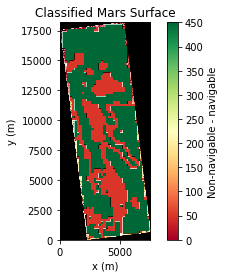

In [13]:
# Classified Mars Surface Plot

for i in range(sub_rows):
    subimg_row = 20*i
    for j in range(sub_columns):
        subimg_column = 20*j
        surface_section = surface[subimg_row:(subimg_row+subimg_size), subimg_column:(subimg_column+subimg_size)]
        if surface_section.min() > 0:
            # 20x20 complete section
            slope_section = slope[subimg_row:(subimg_row+subimg_size), subimg_column:(subimg_column+subimg_size)]
            depression_section = depression[subimg_row:(subimg_row+subimg_size), subimg_column:(subimg_column+subimg_size)]
            rise_section = rise[subimg_row:(subimg_row+subimg_size), subimg_column:(subimg_column+subimg_size)]

            data_to_predict = (1, maxZ, surface_section, slope_section, depression_section, rise_section)

            features = np.zeros([1, n_features])
            slope_sample = data_to_predict[3]
            features[0, 2] = slope_sample.max()
            features[0, 3] = slope_sample.mean()
            features[0, 4] = slope_sample.var()
            features[0, 5] = skew(slope_sample.flatten())
            features[0, 6] = kurtosis(slope_sample.flatten())
            depression_sample = data_to_predict[4]
            features[0, 7] = depression_sample.max()
            features[0, 8] = depression_sample.mean()
            features[0, 9] = depression_sample.var()
            features[0, 10] = skew(depression_sample.flatten())
            features[0, 11] = kurtosis(depression_sample.flatten())
            rise_sample = data_to_predict[5]    
            features[0, 12] = rise_sample.max()
            features[0, 13] = rise_sample.mean()
            features[0, 14] = rise_sample.var()
            features[0, 15] = skew(rise_sample.flatten())
            features[0, 16] = kurtosis(rise_sample.flatten())
            surf = (data_to_predict[2]-data_to_predict[2].min()).astype(int)
            glcm = graycomatrix(surf, distances=[5], angles=[0], levels=1024,
                                symmetric=True, normed=True)
            features[0, 0] = graycoprops(glcm, 'dissimilarity')[0,0]
            features[0, 1] = graycoprops(glcm, 'correlation')[0,0]

            predicted = clf.predict(features)
           
            #print(predicted)
            # fill 20x20 portion with -1 to indicate non-navigable
            out_of_bounds = 0
            ready = 0
            #while(ready != 1):
            for m in range(20):
              for n in range(20):
                  if((map_array_classified[subimg_row+m][subimg_column+n] != -1)):
                    if (predicted == 1): # Non-navigable
                        map_array_classified[subimg_row+m][subimg_column+n] = 50
                    if (predicted == 4): # Navigable
                        map_array_classified[subimg_row+m][subimg_column+n] = 450
                  #ready = 1 if n >= 20 else 0
        #else:
            # 20x20 incomplete section
            # print('empty')



scale = 10.017330185711
n_rows = map_array.shape[0]
n_columns = map_array_classified.shape[1]

cmap = copy.copy(plt.cm.get_cmap('RdYlGn'))
cmap.set_under(color='black')   

ls = LightSource(315, 0)
rgb = ls.shade(map_array_classified, cmap=cmap, vmin = 0, vmax = map_array_classified.max(), vert_exag=2, blend_mode='hsv')

fig, ax = plt.subplots()

im = ax.imshow(rgb, cmap=cmap, vmin = 0, vmax = map_array_classified.max(),
                extent =[0, scale*n_columns, 0, scale*n_rows], 
                interpolation ='nearest', origin ='upper')

cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Non-navigable - navigable')

plt.title('Classified Mars Surface')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.show()


# Rute Planning

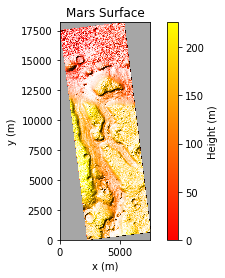

In [14]:
#------------------------------------------------------------------------------------------------------------------
#   Mars map test 
#------------------------------------------------------------------------------------------------------------------

#------------------------------------------------------------------------------------------------------------------
#   Load map data
#------------------------------------------------------------------------------------------------------------------
#image_data = np.load('map.npy')
image_data = map_array
scale = 10.017330185711
n_rows = image_data.shape[0]
n_columns = image_data.shape[1]

#------------------------------------------------------------------------------------------------------------------
#   Show data
#------------------------------------------------------------------------------------------------------------------

cmap = copy.copy(plt.cm.get_cmap('autumn'))
cmap.set_under(color='black')   

ls = LightSource(315, 45)
rgb = ls.shade(image_data, cmap=cmap, vmin = 0, vmax = image_data.max(), vert_exag=2, blend_mode='hsv')

fig, ax = plt.subplots()

im = ax.imshow(rgb, cmap=cmap, vmin = 0, vmax = image_data.max(), 
                extent =[0, scale*n_columns, 0, scale*n_rows], 
                interpolation ='nearest', origin ='upper')

cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Height (m)')

plt.title('Mars Surface')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.show()

In [15]:
# convert from x map coordinate to image_data column
def x2col(x):
    return int(np.round(x/scale))

# convert from y map coordinate to image_data row
def y2row(y):
    return int(n_rows - np.round(y/scale))

# convert from image_data column to x coordinate in map
def col2x(col):
    return col*scale

# convert from image_data row to y coordinate in map
def row2y(row):
    return (n_rows-row)*scale

In [16]:
# function to print a zoomed map with a route
def zoom_map(x1, y1, x2, y2, way):
    # in map:
    #       |------------(x2,y2)
    #       |               |
    #       |               |
    #   (x1,y1)-------------|
    # in array:
    #   (col1,row2)---------|
    #       |               |
    #       |               |
    #       |----------(col2,row1)
    col1 = x2col(x1)
    col2 = x2col(x2)
    row1 = y2row(y1)
    row2 = y2row(y2)
    zoom_area = []
    for i in range(row2, row1):
        temp = []
        for j in range(col1, col2):
            temp.append(image_data[i][j])
        zoom_area.append(temp)
    
    # crop area of image_data 
    zoomed_map = np.array(zoom_area)

    cmap = copy.copy(plt.cm.get_cmap('autumn'))
    cmap.set_under(color='black')   
    ls = LightSource(315, 45)
    rgb = ls.shade(zoomed_map, cmap=cmap, vmin = 0, vmax = zoomed_map.max(), vert_exag=2, blend_mode='hsv')
    fig, ax = plt.subplots()
    im = ax.imshow(rgb, cmap=cmap, vmin = 0, vmax = zoomed_map.max(), 
                        extent =[x1, x2, y1, y2],                       # change extent to desired zoom area
                        interpolation ='nearest', origin ='upper')
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Height (m)')
    plt.title('Enlarged Mars Surface Section')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')

    # print route 
    for i in range(len(way)):
        plt.plot(np.round(col2x(way[i][0])), np.round(row2y(way[i][1])), ".b", markersize=3)

    plt.show()

def zoom_map_navidad(x1, y1, x2, y2, way):
    # in map:
    #       |------------(x2,y2)
    #       |               |
    #       |               |
    #   (x1,y1)-------------|
    # in array:
    #   (col1,row2)---------|
    #       |               |
    #       |               |
    #       |----------(col2,row1)
    col1 = x2col(x1)
    col2 = x2col(x2)
    row1 = y2row(y1)
    row2 = y2row(y2)
    zoom_area = []
    for i in range(row2, row1):
        temp = []
        for j in range(col1, col2):
            temp.append(map_array_classified[i][j])
        zoom_area.append(temp)
    
    # crop area of image_data 
    zoomed_map = np.array(zoom_area)

    cmap = copy.copy(plt.cm.get_cmap('RdYlGn'))
    cmap.set_under(color='black') 
    ls = LightSource(315, 0)
    rgb = ls.shade(zoomed_map, cmap=cmap, vmin = 0, vmax = zoomed_map.max(), vert_exag=2, blend_mode='hsv')
    fig, ax = plt.subplots()

    im = ax.imshow(rgb, cmap=cmap, vmin = 0, vmax = zoomed_map.max(), 
                        extent =[x1, x2, y1, y2],                       # change extent to desired zoom area
                        interpolation ='nearest', origin ='upper')
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Non-navigable - navigable')
    plt.title('Classified Mars Surface')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')

    # print route 
    for i in range(len(way)):
        plt.plot(np.round(col2x(way[i][0])), np.round(row2y(way[i][1])), ".b", markersize=3)

    plt.show()

# calculate the actual distance for a given path
def path_distance(way):
    cost = 0.0
    for i in range(len(way)-1):
        cost += math.sqrt((way[i][0]-way[i+1][0])**2+(way[i][1]-way[i+1][1])**2)
    return cost*scale

In [17]:
# get starting point row and column
# (x,y) = (2850, 6400)
column_i = x2col(2850)
row_i = y2row(6400)

# get final point row and column
# (x,y) = (3150, 6800)
column_f = x2col(3150)
row_f = y2row(6800)

print("Starting point (row, column): (", row_i, ",", column_i,")")
print("Final point (row, column): (", row_f, ",", column_f, ")")

Starting point (row, column): ( 1176 , 285 )
Final point (row, column): ( 1136 , 314 )


In [18]:
import time
import math
from simpleai.search import SearchProblem, astar, greedy, breadth_first, depth_first

# Class containing the methods to solve the maze
class MazeSolver(SearchProblem):

    def __init__(self, board, xi, yi, xf, yf, max_height):      # Init class
        self.board = board
        self.initial = (x2col(xi), y2row(yi))   # convert initial and final points to indexes
        self.goal = (x2col(xf), y2row(yf))
        self.max_height = max_height            # max height difference between positions
        
        super(MazeSolver, self).__init__(initial_state=self.initial)

    # Define the method that takes actions
    # to arrive at the solution
    def actions(self, state):
        x, y = state
        actions = []
        for action in COSTS.keys():
            newx, newy = self.result(state, action)
            if self.board[newy][newx] != -1:
                if (abs(self.board[y][x] - self.board[newy][newx]) < self.max_height):    
                      actions.append(action)
        return actions

   # Update the state based on the action
    def result(self, state, action):
        x, y = state
        
        if action.count("up"):
            y -= 1
        if action.count("down"):
            y += 1
        if action.count("left"):
            x -= 1
        if action.count("right"):
            x += 1

        new_state = (x, y)
        return new_state     

    # Check if we have reached the goal
    def is_goal(self, state):
        return state == self.goal

    # Compute the cost of taking an action
    def cost(self, state, action, state2):
        x, y = state
        newx, newy = self.result(state, action)
        if(map_array_nav[newy][newx]==4):
          return COSTS[action]*2
        else:
          return COSTS[action]
        

        

    # Heuristic that we use to arrive at the solution
    def heuristic(self, state):
        x, y = state
        gx, gy = self.goal

        return math.sqrt((x - gx) ** 2 + (y - gy) ** 2)

if __name__ == "__main__":      # Define the maze
    MAP = image_data.tolist()

# Define cost of moving around the map
cost_regular = 1.0
cost_diagonal = 1.4

# Create the cost dictionary

COSTS = {
    "up": cost_regular,
    "down": cost_regular,
    "left": cost_regular,
    "right": cost_regular,
    "up left": cost_diagonal,
    "up right": cost_diagonal,
    "down left": cost_diagonal,
    "down right": cost_diagonal,
}

In [23]:
# Create maze solver object
#problem = MazeSolver(MAP, 2850, 6400, 3150, 6800, 0.25)
problem = MazeSolver(MAP, 4500, 1500, 6000, 12000, 0.25)

In [24]:
# A* search

ti = time.time()

# Run the solver
result = astar(problem, graph_search=True)
 
tf = time.time()          

# Extract the path
path = [x[1] for x in result.path()]


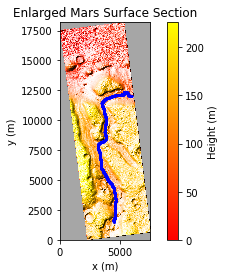

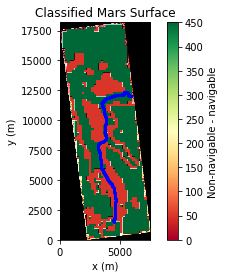

Points within non-navigable areas:  480 / 1430
A* search
Total time (s): 36.225805044174194
Path distance (m): 16069.92466655631


In [25]:

zoom_map(0, 0, scale*n_columns, scale*n_rows, path)
zoom_map_navidad(0, 0, scale*n_columns, scale*n_rows, path)

temp3 = 0 
for i in range(len(path)):
  temp1 = path[i][0]
  temp2 = path[i][1]
  if(map_array_nav[temp2][temp1] == 4):
    temp3 += 1

print("Points within non-navigable areas: ", temp3,"/",len(path))
print("A* search")
print("Total time (s):", tf-ti)
print("Path distance (m):", path_distance(path))

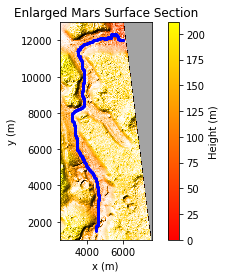

In [28]:
zoom_map(2500, 1000, scale*n_columns, 13000, path)